# Symmetry & Degeneracy in a 2D Infinite Potential Well  
### Square → Rectangle deformation via aspect ratio $(r = L_x/L_y)$

We study the 2D infinite well energy spectrum:

$$
[
E_{n_x,n_y} \propto \frac{n_x^2}{L_x^2} + \frac{n_y^2}{L_y^2}]
$$
Let
$(L_y=1) $ and $ (L_x=r) $

Then

$$
{E}_{n_x,n_y}(r) = \frac{n_x^2}{r^2} + n_y^2
$$

At \(r=1\) (square), exchange symmetry $(x \leftrightarrow y)$ implies $(E_{n_x,n_y}=E_{n_y,n_x})$ producing degeneracy for $(n_x\neq n_y)$.  
For $(r\neq 1)$ (rectangle), this symmetry is broken and degeneracies split.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass


In [2]:
def spectrum_2d_infinite_well(nmax: int, r: float) -> pd.DataFrame:
    """
    Returns a DataFrame of states (nx, ny) with dimensionless energies:
        E~(nx,ny;r) = nx^2 / r^2 + ny^2
    assuming Ly = 1, Lx = r.
    """
    rows = []
    for nx in range(1, nmax + 1):
        for ny in range(1, nmax + 1):
            E = (nx**2) / (r**2) + (ny**2)
            rows.append((nx, ny, E))
    df = pd.DataFrame(rows, columns=["nx", "ny", "E"])
    df = df.sort_values("E", kind="mergesort").reset_index(drop=True)
    return df


def cluster_degeneracies(energies: np.ndarray, tol: float = 1e-10):
    """
    Group sorted energies into clusters where adjacent energies differ by <= tol.
    Returns list of clusters, each cluster is a list of indices.
    """
    clusters = []
    start = 0
    for i in range(1, len(energies)):
        if abs(energies[i] - energies[i-1]) > tol:
            clusters.append(list(range(start, i)))
            start = i
    clusters.append(list(range(start, len(energies))))
    return clusters


def degeneracy_table(df: pd.DataFrame, k: int, tol: float = 1e-10) -> pd.DataFrame:
    """
    For the lowest k energies, return a table describing degeneracy clusters.
    """
    sub = df.iloc[:k].copy()
    clusters = cluster_degeneracies(sub["E"].to_numpy(), tol=tol)

    out_rows = []
    for c_id, idxs in enumerate(clusters):
        states = sub.loc[idxs, ["nx", "ny"]].to_numpy().tolist()
        E0 = float(sub.loc[idxs[0], "E"])
        out_rows.append({
            "cluster_id": c_id,
            "degeneracy": len(idxs),
            "E": E0,
            "states": states
        })
    return pd.DataFrame(out_rows)


In [3]:
nmax = 12      # basis cutoff
k = 40         # number of lowest levels to examine
tol = 1e-10

df_sq = spectrum_2d_infinite_well(nmax=nmax, r=1.0)
deg_sq = degeneracy_table(df_sq, k=k, tol=tol)

deg_sq


,cluster_id,degeneracy,E,states
0,0,1,2.0,"[[1, 1]]"
1,1,2,5.0,"[[1, 2], [2, 1]]"
2,2,1,8.0,"[[2, 2]]"
3,3,2,10.0,"[[1, 3], [3, 1]]"
4,4,2,13.0,"[[2, 3], [3, 2]]"
5,5,2,17.0,"[[1, 4], [4, 1]]"
6,6,1,18.0,"[[3, 3]]"
7,7,2,20.0,"[[2, 4], [4, 2]]"
8,8,2,25.0,"[[3, 4], [4, 3]]"
9,9,2,26.0,"[[1, 5], [5, 1]]"


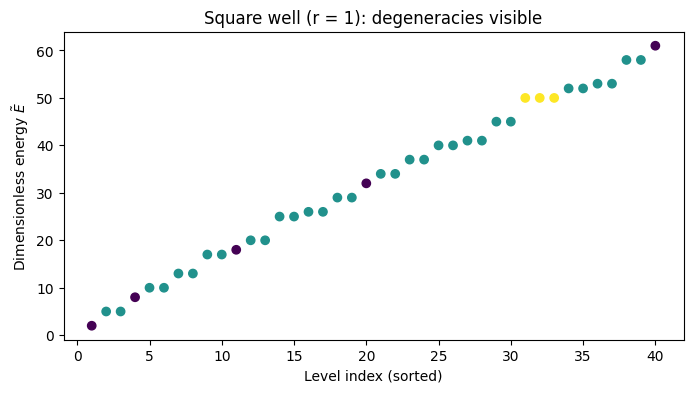

In [4]:
def plot_levels_with_degeneracy(df: pd.DataFrame, k: int, tol: float = 1e-10, title: str = ""):
    sub = df.iloc[:k].copy()
    clusters = cluster_degeneracies(sub["E"].to_numpy(), tol=tol)

    # Map index -> degeneracy size
    deg_size = np.zeros(k, dtype=int)
    for idxs in clusters:
        for i in idxs:
            deg_size[i] = len(idxs)

    plt.figure(figsize=(8, 4))
    x = np.arange(1, k+1)
    plt.scatter(x, sub["E"], c=deg_size)  # default colormap is fine
    plt.xlabel("Level index (sorted)")
    plt.ylabel("Dimensionless energy $\\tilde{E}$")
    plt.title(title or f"Lowest {k} energy levels (colored by degeneracy)")
    plt.show()

plot_levels_with_degeneracy(df_sq, k=k, tol=tol, title="Square well (r = 1): degeneracies visible")


## Splitting under rectangle deformation

We identify degenerate clusters at \(r=1\), then sweep \(r\) away from 1 and track the energies of the *same* \((n_x,n_y)\) states.

This shows how degeneracy is lifted when \(L_x \neq L_y\).


In [5]:
# Choose a few degenerate clusters from r=1 to track
# Example: track the first 3 clusters with degeneracy > 1
degenerate_clusters = deg_sq[deg_sq["degeneracy"] > 1].head(3)
degenerate_clusters


,cluster_id,degeneracy,E,states
1,1,2,5.0,"[[1, 2], [2, 1]]"
3,3,2,10.0,"[[1, 3], [3, 1]]"
4,4,2,13.0,"[[2, 3], [3, 2]]"


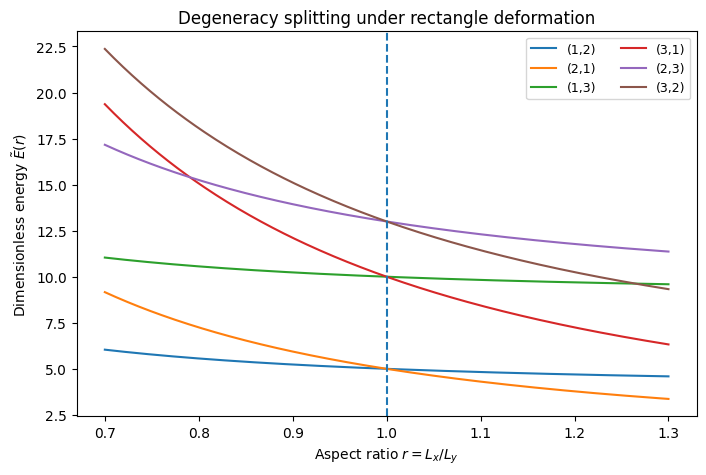

In [6]:
r_values = np.linspace(0.7, 1.3, 250)

plt.figure(figsize=(8, 5))

for _, row in degenerate_clusters.iterrows():
    states = row["states"]  # list of [nx, ny]
    for (nx, ny) in states:
        E_curve = (nx**2)/(r_values**2) + (ny**2)
        plt.plot(r_values, E_curve, label=f"({nx},{ny})")

plt.axvline(1.0, linestyle="--")
plt.xlabel("Aspect ratio $r = L_x/L_y$")
plt.ylabel("Dimensionless energy $\\tilde{E}(r)$")
plt.title("Degeneracy splitting under rectangle deformation")
plt.legend(ncols=2, fontsize=9)
plt.show()


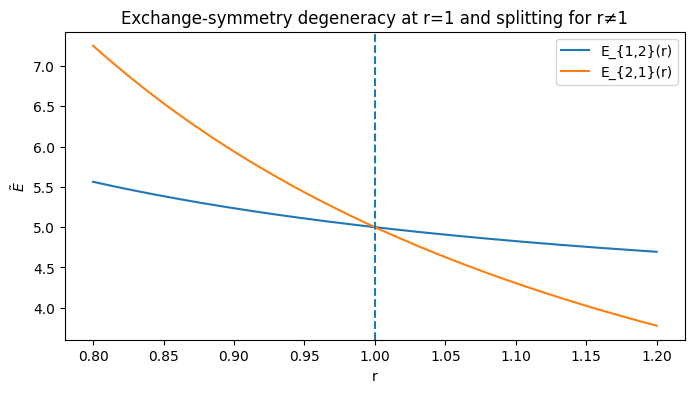

In [7]:
def swap_pair_demo(nx: int, ny: int, r_values: np.ndarray):
    E1 = (nx**2)/(r_values**2) + (ny**2)
    E2 = (ny**2)/(r_values**2) + (nx**2)
    return E1, E2

r_values = np.linspace(0.8, 1.2, 200)
nx, ny = 1, 2
E12, E21 = swap_pair_demo(nx, ny, r_values)

plt.figure(figsize=(8,4))
plt.plot(r_values, E12, label=f"E_{{{nx},{ny}}}(r)")
plt.plot(r_values, E21, label=f"E_{{{ny},{nx}}}(r)")
plt.axvline(1.0, linestyle="--")
plt.xlabel("r")
plt.ylabel("$\\tilde{E}$")
plt.title("Exchange-symmetry degeneracy at r=1 and splitting for r≠1")
plt.legend()
plt.show()


## Takeaways
- At \(r=1\), exchange symmetry $(x \leftrightarrow y)$ forces $(E_{n_x,n_y}=E_{n_y,n_x})$, so $((n_x,n_y))$ and $((n_y,n_x))$ are degenerate when $(n_x\neq n_y)$.
- When $(r \neq 1)$, the symmetry is broken and these pairs split smoothly with $(r)$.
- This is a concrete example of: **symmetry → degeneracy; symmetry breaking → degeneracy lifting**.
